# Simple Case Using Cramer Rao Bound

Set up a spring-mass-damper system as a simple example to try this concept. Start by defining the system dynamics. 

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from filterpy.kalman import KalmanFilter
from scipy.linalg import expm
from scipy.signal import cont2discrete

# Spring-mass-damper parameters
m = 1.0  # Mass (kg)
c = 0.5  # Damping coefficient (Ns/m)
k = 2.0  # Spring constant (N/m)

# Continuous-time state-space matrices
A_c = np.array([[0, 1],
                [-k/m, -c/m]])
B_c = np.array([[0],
                [1/m]])

C_true = np.eye(2)

C = [
    np.array([[1, 0], [0, 1]]),
    np.array([[1, 0], [0, 0]]),
    np.array([[3.14, 0], [0, 1]]), 
    np.array([[3.14, 0], [0, 1]]),
    np.array([[1, 0], [0, 1]]),
]

# Process and measurement noise
Q = np.array([[1e-4, 0], 
              [0, 1e-4]])  # Process noise covariance
R = np.array([[0.05, 0], 
              [0, 0.05]])  # Measurement noise covariance

# Discrete time system for kalman filter
dt = 0.1  # Time step
A_d = expm(A_c * dt)
B_d = np.linalg.solve(A_c, (A_d - np.eye(2))) @ B_c

# Initial conditions
x0 = np.array([1.0, 0.0])  # Initial displacement and velocity


# Simulate True System

In [9]:
# Simulate the true system
np.random.seed(42)
n_steps = 100 
true_states = []
measurements = []
for _ in range(n_steps):
    # Simulate true dynamics
    x_true = A_d @ x0 + np.random.multivariate_normal([0, 0], Q).T
    true_states.append(x_true)

    # Simulate noisy measurements
    z = C_true @ x_true + np.random.multivariate_normal([0, 0], R).T
    measurements.append(z)

    # Update for the next time step
    x0 = x_true

true_states = np.array(true_states)
measurements = np.array(measurements)

# Run KF

Then, use the  Kalman filter to generate state estimates from simulated measurments. Make sure to use the 3 sigma bound to set up the estimation range. This block runs the Kalman Filter for every subgroup of C matrices. 

In [10]:
nums = np.zeros(shape=(n_steps, 4))
data = []

for i in range(len(C)):
    system = (A_c, B_c, np.eye(2), 0)
    A_d, B_d, _, _, _ = cont2discrete(system, dt)
    Q = np.eye(2) * 1e-4
    R = np.eye(C[i].shape[0]) * 0.05

    # Kalman Filter setup
    kf = KalmanFilter(dim_x=2, dim_z=2)
    kf.F = A_d  # Discretized A matrix
    kf.H = C[i]  # Measurement matrix C
    kf.Q = Q  # Process noise covariance Q
    kf.R = R  # Measurement noise covariance R
    kf.P = np.eye(2) * 500  # Initial state covariance P
    kf.x = x0  # Initial state estimate

    data_at_this_C = pd.DataFrame(nums, columns=['position', 'velocity', 'position uncertainty', 'velocity uncertainty'])
    
    for j in range(len(measurements)): # use kalman filter to estimate the state and add it to my dataframe
        kf.predict()
        kf.update(measurements[j])
        data_at_this_C.iloc[j, 0]= kf.x[0]
        data_at_this_C.iloc[j, 1] = kf.x[1]
        three_sigma = 3 * np.sqrt(np.diag(kf.P)) # make sure to multiply by 3 for 3 sigma!!
        data_at_this_C.iloc[j, 2]= three_sigma[0]
        data_at_this_C.iloc[j, 3] = three_sigma[1]
    
    data.append(data_at_this_C.copy())


# Plot Results

Finally, plot the results. 

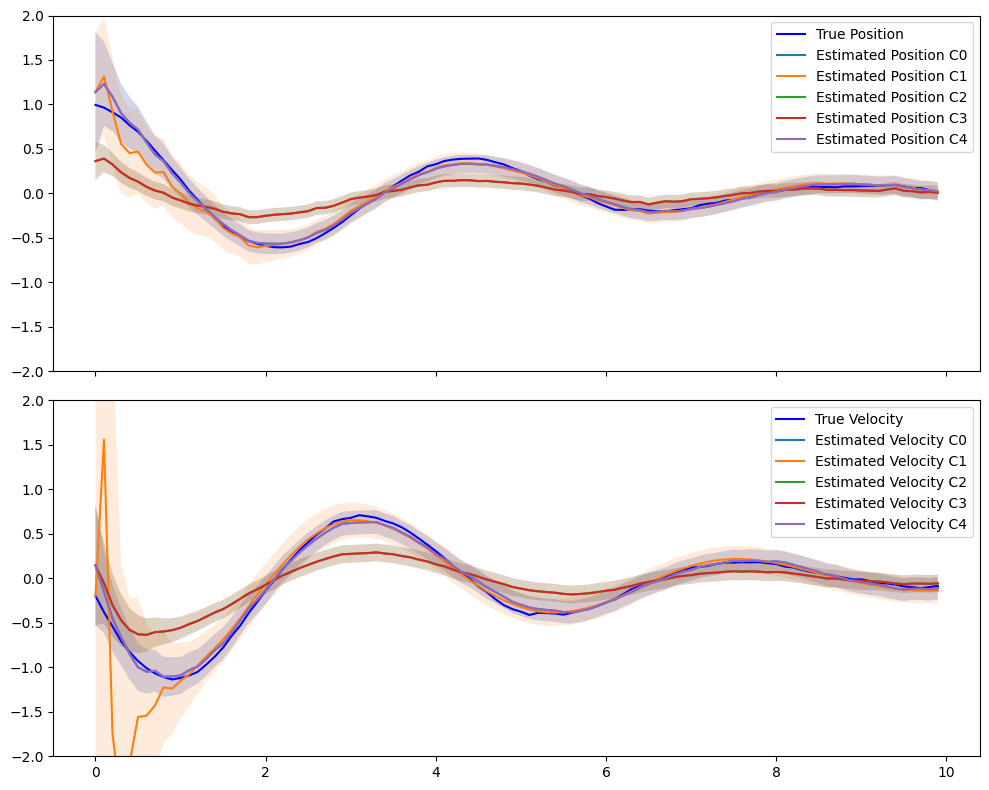

In [11]:
# Plot results from the data dataframe
time = np.arange(0, n_steps * dt, dt)
fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

axs[0].plot(time, true_states[:, 0], label="True Position", color="blue")
for i in range(len(data)):
    position_array = np.array(data[i]['position'])
    axs[0].plot(time, position_array, label=f"Estimated Position C{i}")
    axs[0].fill_between(time, position_array - np.array(data[i]['position uncertainty']), position_array + np.array(data[i]['position uncertainty']), alpha=0.15)
axs[0].set_ylim(-2, 2)

axs[1].plot(time, true_states[:, 1], label="True Velocity", color="blue")
for i in range(len(data)):
    velocity_array = np.array(data[i]['velocity'])
    axs[1].plot(time, velocity_array, label=f"Estimated Velocity C{i}")
    axs[1].fill_between(time, velocity_array - np.array(data[i]['velocity uncertainty']), velocity_array + np.array(data[i]['velocity uncertainty']), alpha=0.15)
axs[1].set_ylim(-2, 2)

axs[0].legend()
axs[1].legend()
plt.tight_layout()
plt.show()


# Check Overlap and Heatmap

Now, I want to check if the state estimates for position overlap with the uncertainty ranges of all other position estimates.    

[[1.   0.97 0.51 0.51 1.  ]
 [1.   1.   0.68 0.68 1.  ]
 [0.4  0.42 1.   1.   0.4 ]
 [0.4  0.42 1.   1.   0.4 ]
 [1.   0.97 0.51 0.51 1.  ]]


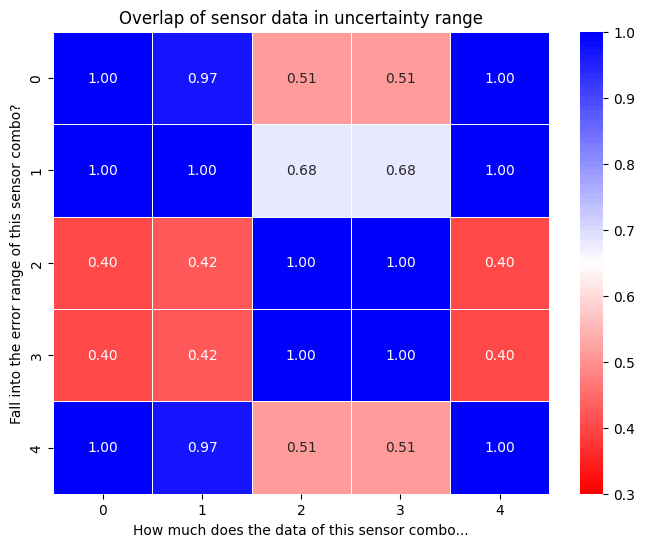

In [12]:
# cheeck if a state estimate for position overlaps with the uncertainty range of all other state estimates for position for at least 90% of the time and print results
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
overlapvals_pos = np.ones((5,5))
for i in range(len(data)):
    for j in range(len(data)):
        if i != j:
            overlap = np.sum((data[i]['position'] + data[i]['position uncertainty'] > data[j]['position']) & (data[i]['position'] - data[i]['position uncertainty'] < data[j]['position'])) / len(data[i])
            overlapvals_pos[i,j] = overlap
print(overlapvals_pos)
# plot overlapvals onto a red and blue heatmap with values from 0 to 1
# Define custom colormap
colors = ["red", "white", "blue"]  # Define the colors for your gradient
cmap_name = "custom_colormap"
custom_cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=100)

# Create the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(overlapvals_pos, cmap=custom_cmap, annot=True, fmt=".2f", linewidths=.5, vmin=0.3, vmax=1)

# Add title and labels
plt.title("Overlap of sensor data in uncertainty range")
plt.xlabel("How much does the data of this sensor combo...")
plt.ylabel("Fall into the error range of this sensor combo?")

# Show the plot
plt.show()


I will now do the same with veloctiy. 

[[1.   0.93 0.57 0.57 1.  ]
 [1.   1.   0.65 0.65 1.  ]
 [0.43 0.35 1.   1.   0.43]
 [0.43 0.35 1.   1.   0.43]
 [1.   0.93 0.57 0.57 1.  ]]


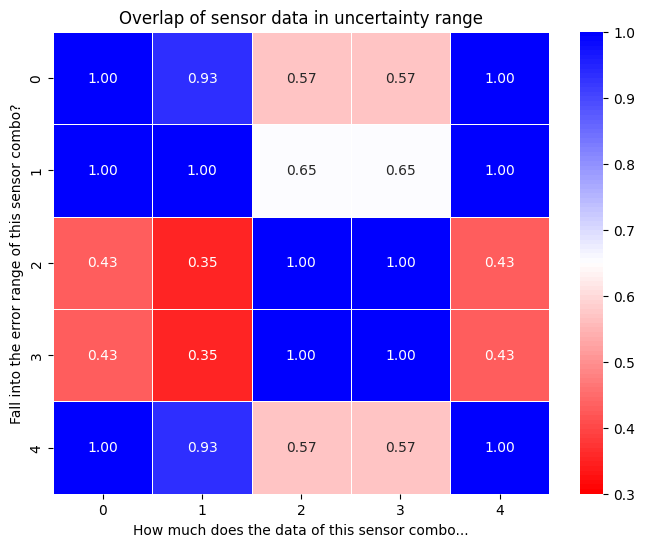

In [13]:
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
overlapvals_vel = np.ones((5,5))
# cheeck if a state estimate for velocity overlaps with the uncertainty range of all other state estimates for velocity for at least 90% of the time and print results. Do the same thing as the above block
for i in range(len(data)):
    for j in range(len(data)):
        if i != j:
            overlap = np.sum((data[i]['velocity'] + data[i]['velocity uncertainty'] > data[j]['velocity']) & (data[i]['velocity'] - data[i]['velocity uncertainty'] < data[j]['velocity'])) / len(data[i])
            overlapvals_vel[i,j] = overlap
print(overlapvals_vel)
# plot overlapvals onto a red and blue heatmap with values from 0 to 1
# Define custom colormap
colors = ["red", "white", "blue"]  # Define the colors for your gradient
cmap_name = "custom_colormap"
custom_cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=100)

# Create the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(overlapvals_vel, cmap=custom_cmap, annot=True, fmt=".2f", linewidths=.5, vmin=0.3, vmax=1)

# Add title and labels
plt.title("Overlap of sensor data in uncertainty range")
plt.xlabel("How much does the data of this sensor combo...")
plt.ylabel("Fall into the error range of this sensor combo?")

# Show the plot
plt.show()


# Sort Heatmap
Now, we want to sort the heatmaps to make visualizing the incorrect state estimates easier

[[1. 1. 0. 0. 1.]
 [1. 1. 0. 0. 1.]
 [0. 0. 1. 1. 0.]
 [0. 0. 1. 1. 0.]
 [1. 1. 0. 0. 1.]]


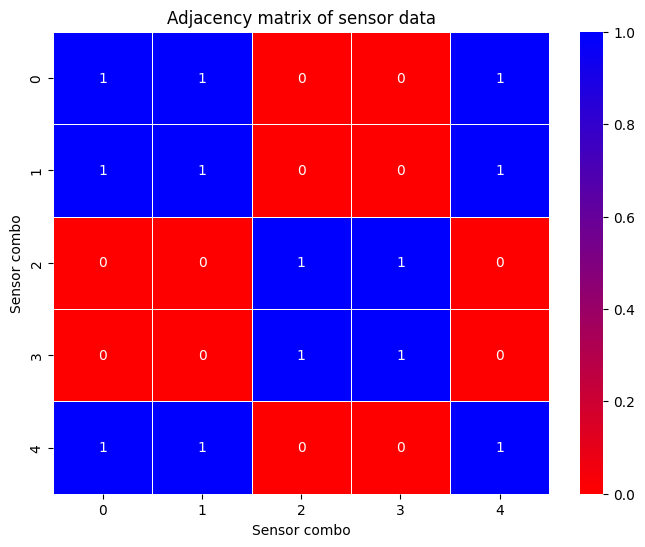

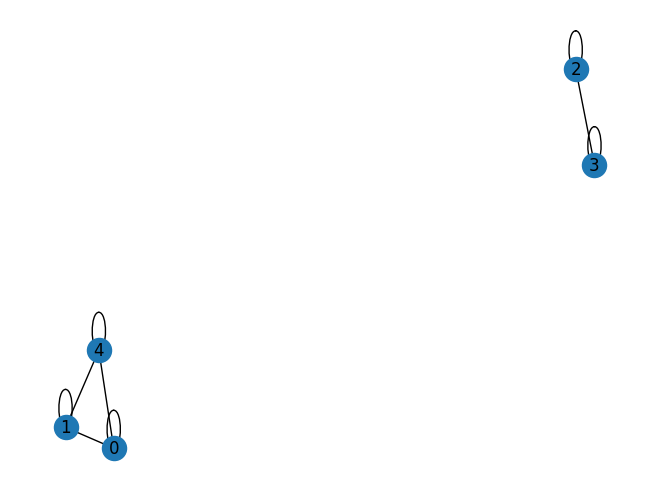

Sensor combo 0 has 3.0 connections
Sensor combo 1 has 3.0 connections
Sensor combo 2 has 2.0 connections
Sensor combo 3 has 2.0 connections
Sensor combo 4 has 3.0 connections
Sensor combo 2 has the least number of connections
Sensor combo 3 has the least number of connections

[2, 3]


In [14]:
# I now want to make an adjacency matrix using the overlapvals_pos and overlapvals_vel matrices. I will use the following rule: if the overlap of the position data is greater than 0.9 and the overlap of the velocity data is greater than 0.9, then the two sensors are connected. I will then plot the adjacency matrix as a heatmap
adjacency_matrix = np.zeros((5,5))
for i in range(len(data)):
    for j in range(len(data)):
        if overlapvals_pos[i,j] > 0.9 and overlapvals_vel[i,j] > 0.9:
            adjacency_matrix[i,j] = 1
print(adjacency_matrix)
# plot the adjacency matrix as a heatmap with values from 0 to 1. 1 is blue and 0 is red
# Define custom colormap
colors = ["red", "blue"]  # Define the colors for your gradient
cmap_name = "custom_colormap"
custom_cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=100)
# plot the adjacency matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(adjacency_matrix, cmap=custom_cmap, annot=True, fmt=".0f", linewidths=.5, vmin=0, vmax=1)
# Add title and labels
plt.title("Adjacency matrix of sensor data")
plt.xlabel("Sensor combo")
plt.ylabel("Sensor combo")
# Show the plot
plt.show()

# I now want to make the adjacency matrix into a Nauru graph and plot it
import networkx as nx
G = nx.from_numpy_array(adjacency_matrix)
nx.draw(G, with_labels=True)
plt.show()

# now, print the number of connections for each sensor combo
for i in range(len(data)):
    print(f"Sensor combo {i} has {np.sum(adjacency_matrix[i])} connections")

least_connections = []
# now, print the sensor combos with the least number of connections
min_connections = np.min(np.sum(adjacency_matrix, axis=1))
for i in range(len(data)):
    if np.sum(adjacency_matrix[i]) == min_connections:
        print(f"Sensor combo {i} has the least number of connections")
        least_connections.append(i)
print()
print(least_connections)


In [15]:
print('done')

done
